In [1]:
#%pip install optuna -q

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import warnings

from sklearn import datasets as data
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift, estimate_bandwidth
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import hdbscan

# Cấu hình để ẩn log của Optuna trong quá trình tối ưu hóa
optuna.logging.set_verbosity(optuna.logging.WARNING)
# Bỏ qua các cảnh báo về việc không thể tính score khi chỉ có 1 cụm
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 120, 'linewidths':0}

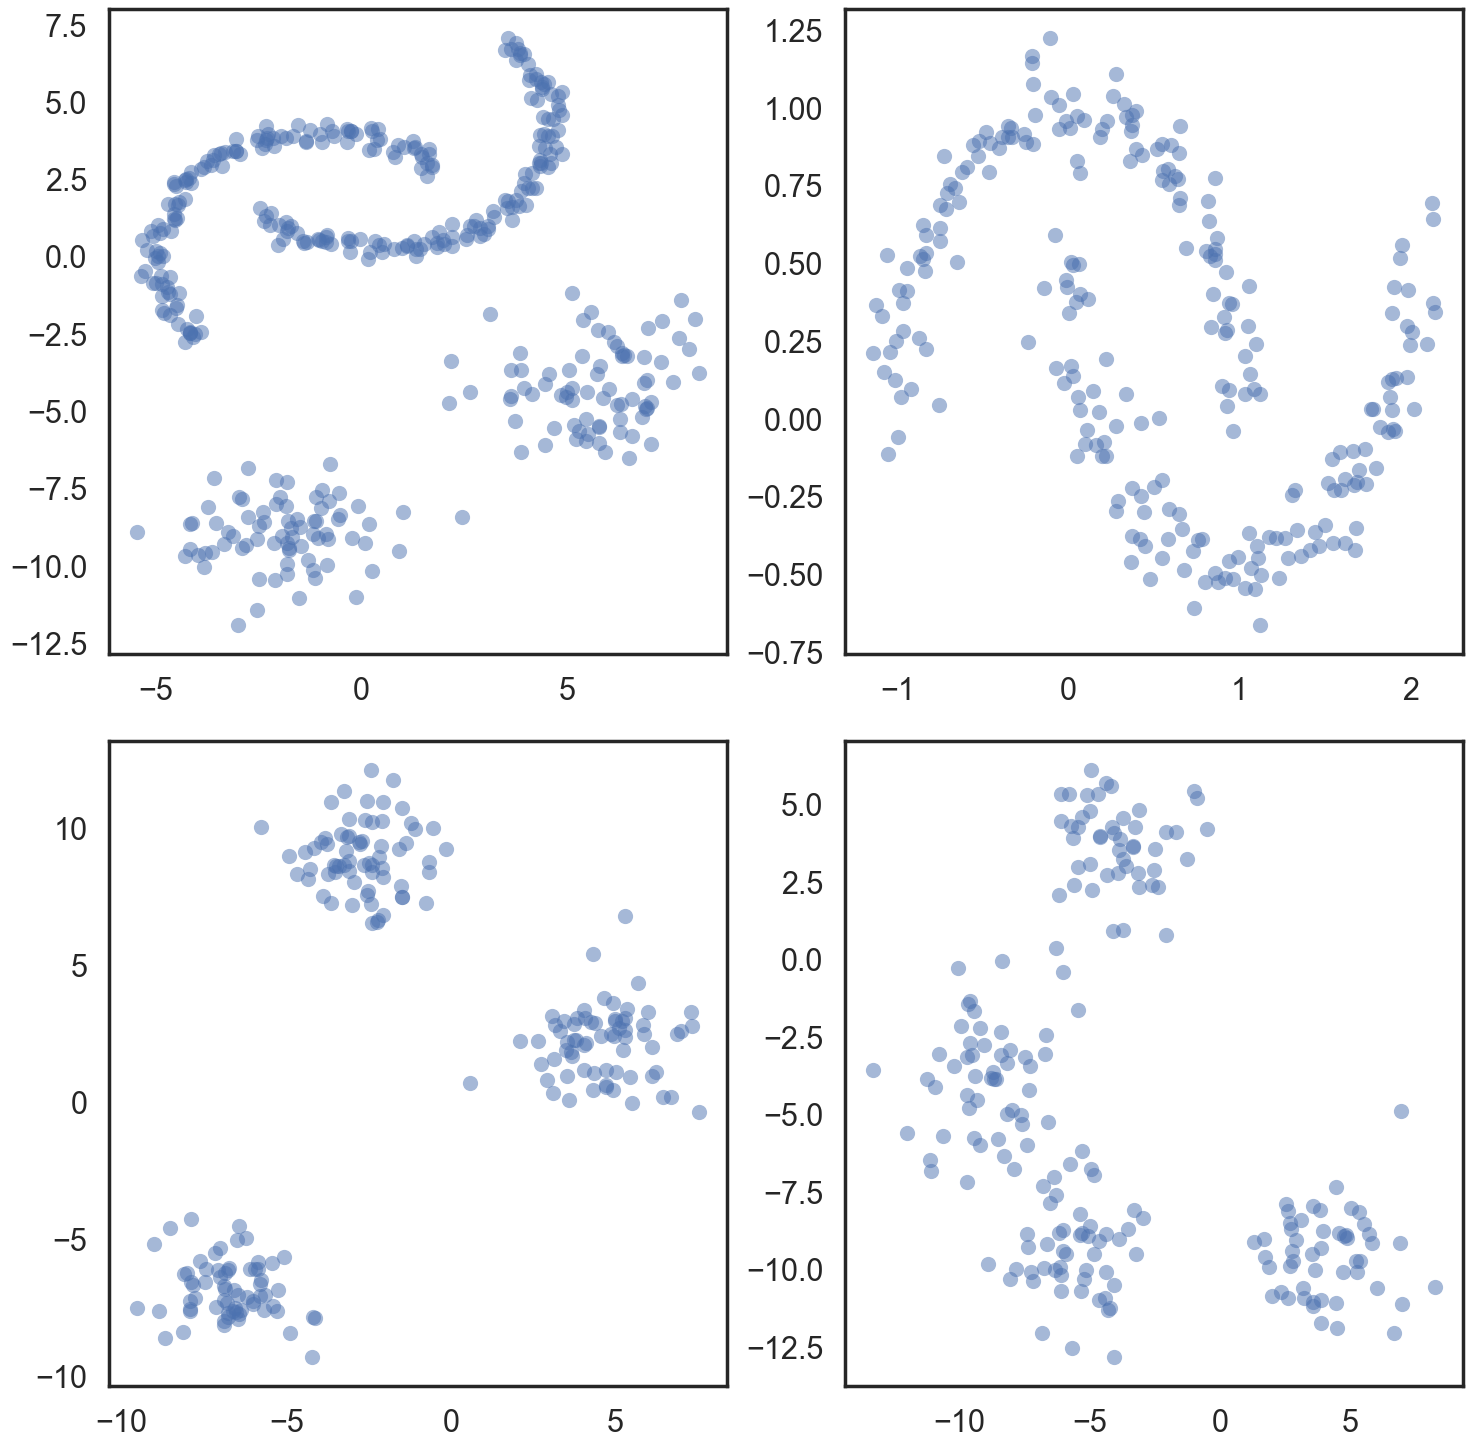

In [4]:
moons_1, _ = data.make_moons(n_samples=250, noise=0.045, random_state= 42)
blobs_1, _ = data.make_blobs(n_samples=150, cluster_std=1.25, random_state=40, centers = 2)
scale = 4.0 # phóng to
theta = 0.75 # góc xoay (radians), để 0 nếu không muốn xoay
R = np.array([[np.cos(theta), -np.sin(theta)],
              [np.sin(theta),  np.cos(theta)]])
moons_transformed = moons_1.dot(R.T) * scale + np.array([-1.0, 0.0])  # dịch sang trái 3 đơn vị
test_data = np.vstack([moons_transformed, blobs_1])

moons_2, _ = data.make_moons(n_samples=100, noise=0.05, random_state= 42)
moons_3, _ = data.make_moons(n_samples=150, noise=0.105, random_state= 42)
test_data2 = np.vstack([moons_2, moons_3])

# Case 2
blobs_2, _ = data.make_blobs(n_samples=200, cluster_std=1.25, random_state=42, centers = 3)

# Case 3
blobs_3, _ = data.make_blobs(n_samples=200, cluster_std=1.5, random_state=21, centers = 4)


fig, axes = plt.subplots(2, 2, figsize=(15, 15))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]
ax1.scatter(test_data[:, 0], test_data[:, 1], color='b', **plot_kwds)
ax2.scatter(test_data2[:, 0], test_data2[:, 1], color='b', **plot_kwds)
ax3.scatter(blobs_2.T[0], blobs_2.T[1], color='b', **plot_kwds)
ax4.scatter(blobs_3.T[0], blobs_3.T[1], color='b', **plot_kwds)
plt.tight_layout()
plt.show()

In [5]:
"""Vì so sánh công bằng không phải là thực hiện chạy thuật toán trên cùng một bộ tham số,
mà là chạy từng thuật toán trên bộ tham số tốt nhất của chúng. Do đó, ta thực hiện
tối ưu hóa từng mô hình rồi so sánh.

Chỉ số so sánh:
DBCV - Silhouette score

Mô hình so sánh:
Khác hướng tiếp cận: K-Means (phân cụm phân hoạch), HAC (phân cụm phân cấp)
Cùng hướng tiếp cận (phân cụm mật độ): DBSCAN, Mean Shift"""

# Vì Silhouette score không thích hợp để đánh giá các cụm "không lồi", nên kết hợp cả dbcv
def calculate_scores(X, labels):
    """Hàm phụ để tính cả hai score và xử lý các trường hợp lỗi."""
    unique_labels = np.unique(labels)
    
    # Bỏ qua điểm nhiễu (-1)
    core_samples_mask = labels != -1
    
    # Chỉ tính score nếu có nhiều hơn 1 cụm (không tính cụm nhiễu)
    if len(unique_labels[unique_labels != -1]) > 1:
        X_core = X[core_samples_mask]
        labels_core = labels[core_samples_mask]
        
        try:
            dbcv = hdbscan.validity.validity_index(X_core, labels_core, metric='euclidean')
        except Exception:
            dbcv = -1.0 # Trả về điểm tệ nếu có lỗi
        
        try:
            silhouette = silhouette_score(X, labels)
        except Exception:
            silhouette = -1.0
    else:
        dbcv = -1.0
        silhouette = -1.0
        
    return dbcv, silhouette

In [6]:
"""Mặc dù HDBSCAN có rất nhiều tham số để thử tinh chỉnh (xem file algorithmdemo), 
nhưng trên thực nghiệm chỉ có hai tham số quan trọng nhất cần tinh chỉnh 
là min_samples và min_cluster_size"""

# Tối ưu hóa HDBSCAN
def objective_hdbscan(trial, X):
    min_cluster_size = trial.suggest_int('min_cluster_size', 2, 20)
    min_samples = trial.suggest_int('min_samples', 2, min_cluster_size)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    clusterer.fit(X)
    dbcv, silhouette = calculate_scores(X, clusterer.labels_)
    trial.set_user_attr("silhouette", silhouette) # Lưu silhouette để tham khảo
    return dbcv

In [7]:
# Tối ưu hóa Mean Shift
def objective_meanshift(trial, X):
    # Ước tính bandwidth để có một khoảng tìm kiếm hợp lý
    estimated_bw = estimate_bandwidth(X, quantile=0.2)
    bandwidth = trial.suggest_float('bandwidth', estimated_bw * 0.5, estimated_bw * 2.0)
    
    clusterer = MeanShift(bandwidth=bandwidth)
    clusterer.fit(X)
    dbcv, silhouette = calculate_scores(X, clusterer.labels_)
    trial.set_user_attr("silhouette", silhouette)
    return dbcv

In [8]:
# Tối ưu hóa DBSCAN

In [9]:
# K-Means

# HAC


Đang xử lý bộ dữ liệu: Moons & Blobs
Tối ưu hóa Mean Shift 
Mean Shift hoàn thành. Best DBCV: 0.6308, Silhouette: 0.5385
Tối ưu hóa HDBSCAN 
HDBSCAN hoàn thành. Best DBCV: 0.5867, Silhouette: 0.4431

Đang xử lý bộ dữ liệu: Moons
Tối ưu hóa Mean Shift 
Mean Shift hoàn thành. Best DBCV: 0.0695, Silhouette: 0.4261
Tối ưu hóa HDBSCAN 
HDBSCAN hoàn thành. Best DBCV: 0.4090, Silhouette: 0.2328

Đang xử lý bộ dữ liệu: Simple Blobs
Tối ưu hóa Mean Shift 
Mean Shift hoàn thành. Best DBCV: 0.6866, Silhouette: 0.8085
Tối ưu hóa HDBSCAN 
HDBSCAN hoàn thành. Best DBCV: 0.6866, Silhouette: 0.8085

Đang xử lý bộ dữ liệu: Overlapping Blobs
Tối ưu hóa Mean Shift 
Mean Shift hoàn thành. Best DBCV: 0.4995, Silhouette: 0.6263
Tối ưu hóa HDBSCAN 
HDBSCAN hoàn thành. Best DBCV: 0.6335, Silhouette: 0.5393

Quá trình tối ưu hóa đã hoàn tất


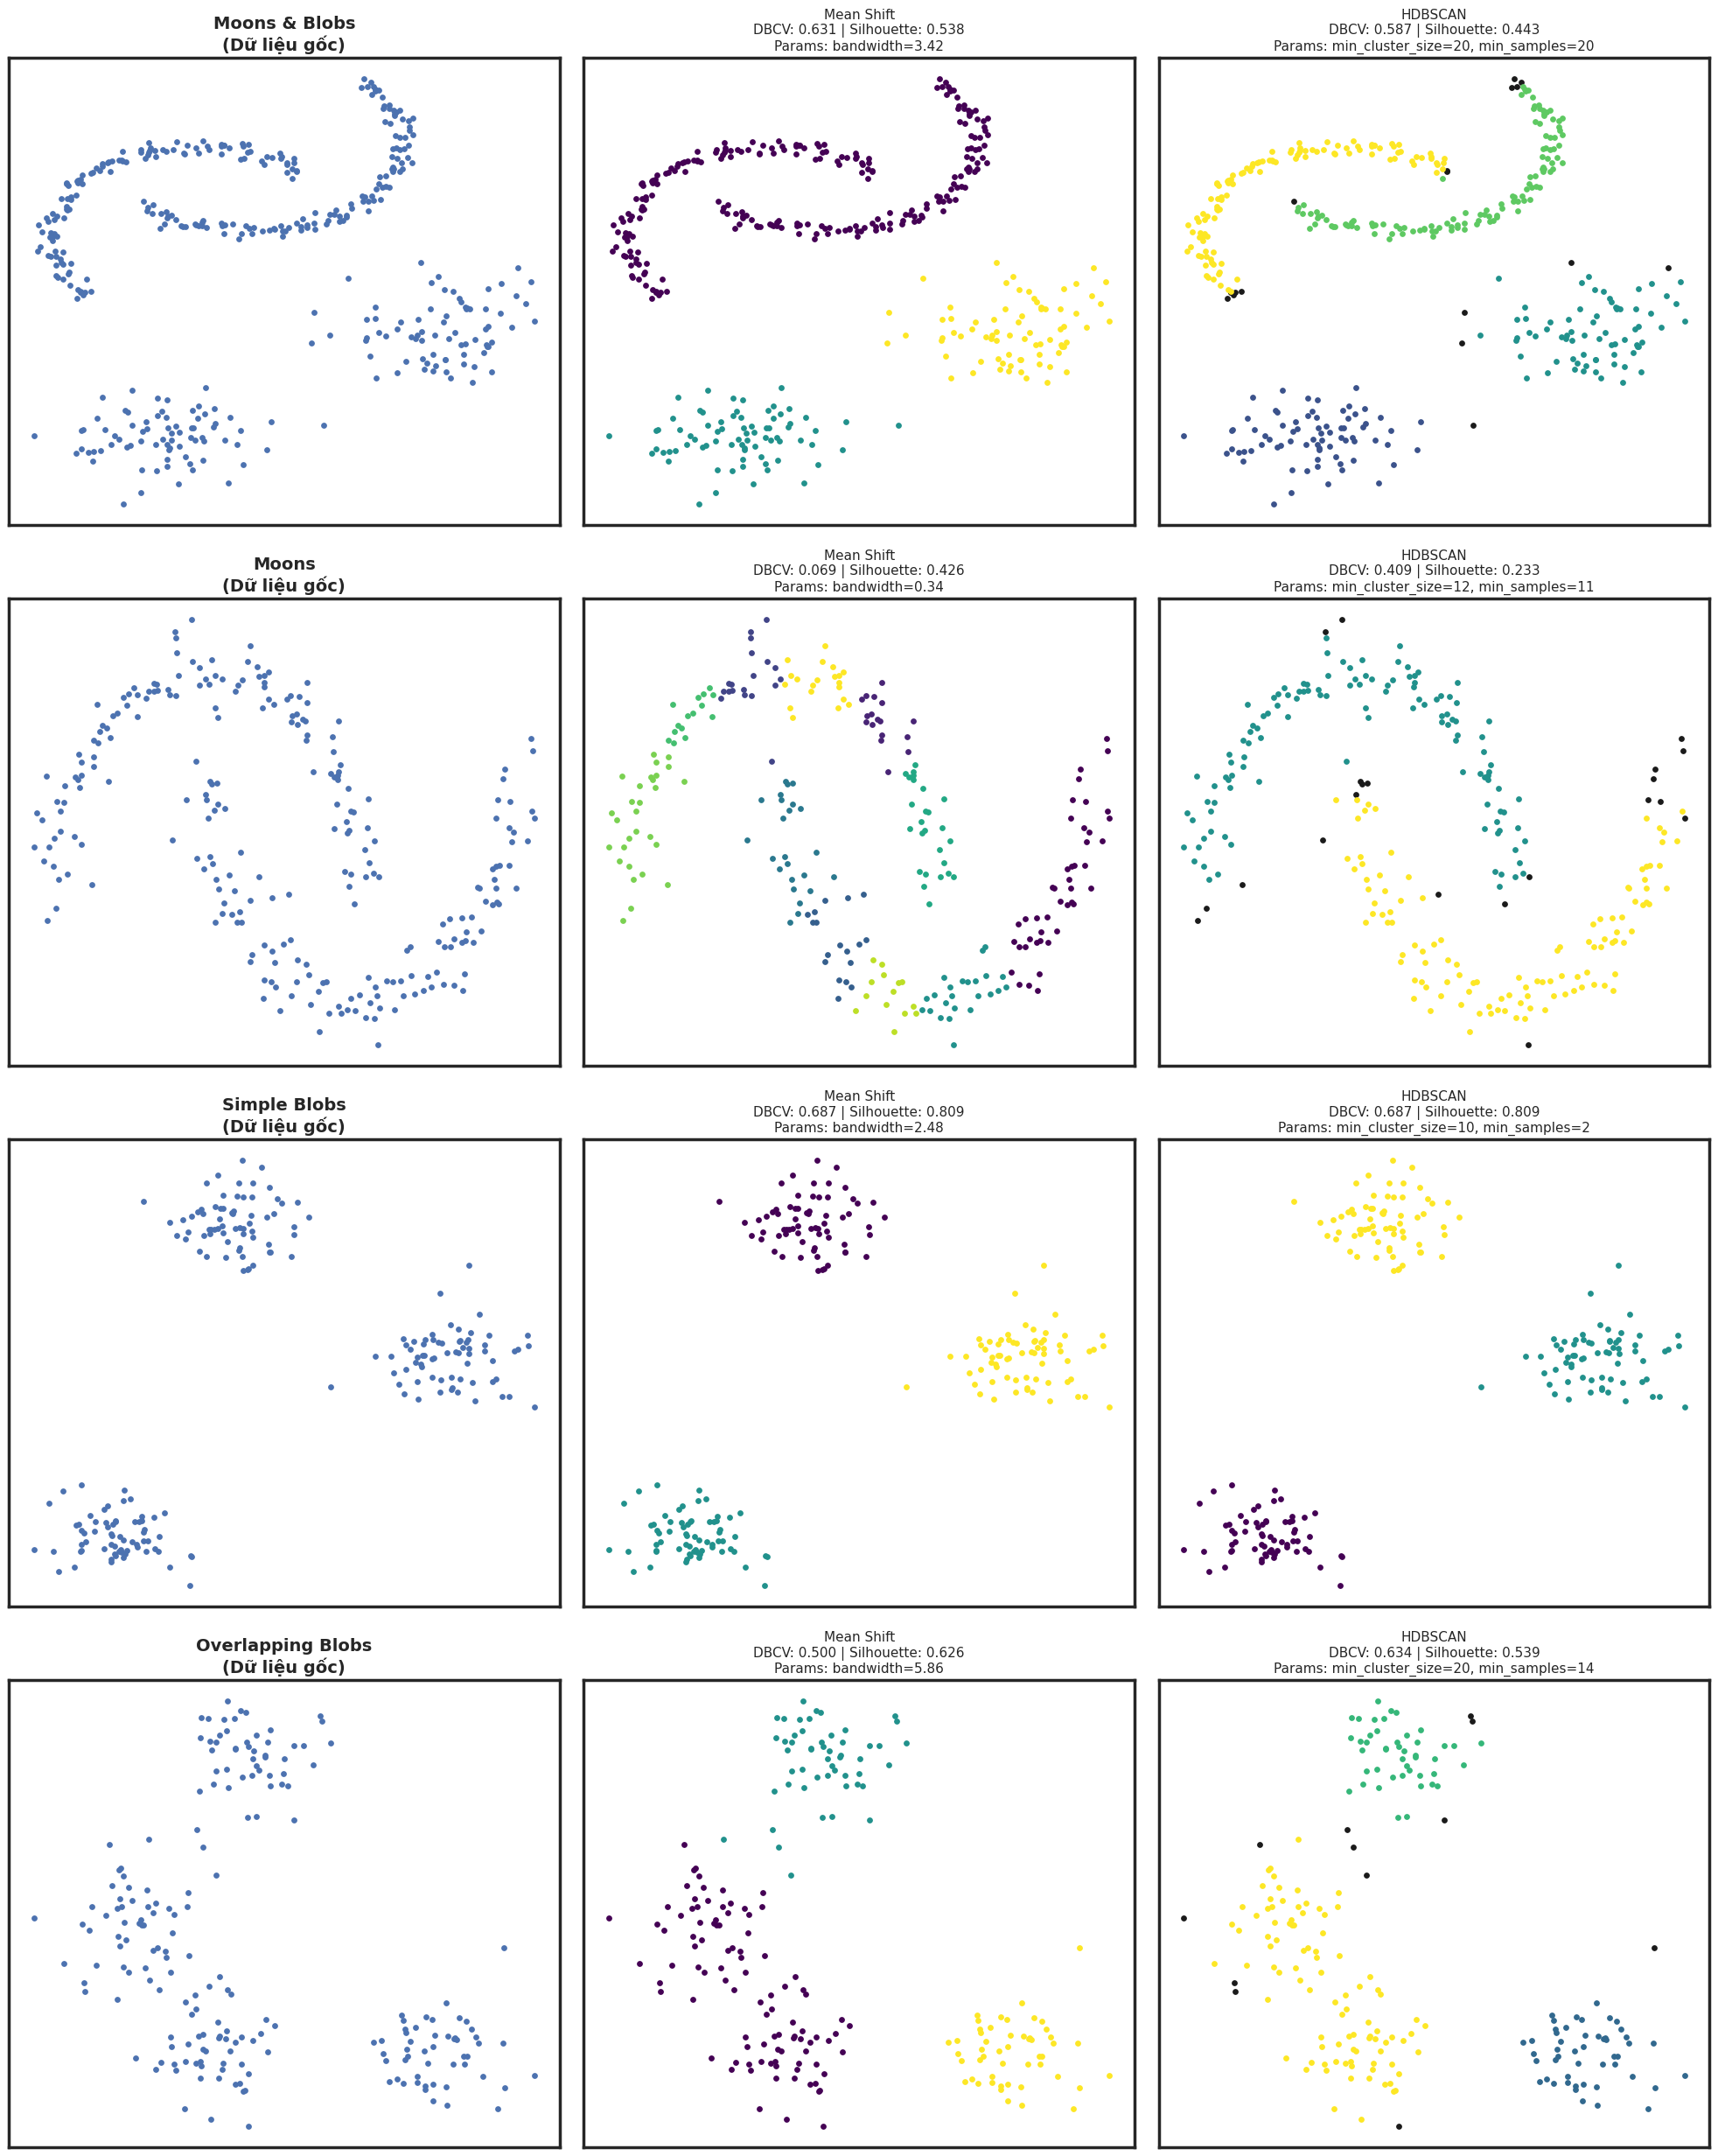

In [10]:
N_TRIALS = 30
datasets = {
    "Moons & Blobs": test_data,
    "Moons": test_data2,
    "Simple Blobs": blobs_2,
    "Overlapping Blobs": blobs_3
}

models_to_optimize = {
    "Mean Shift": objective_meanshift,
    "HDBSCAN": objective_hdbscan
    # Nếu bà có dùng optuna để tối ưu hóa cho ba cái kia thì cứ chèn vào nha
}

results = {}

for name, data_scaled in datasets.items():
    print(f"\nĐang xử lý bộ dữ liệu: {name}")
    results[name] = {}
    for model_name, objective_func in models_to_optimize.items():
        print(f"Tối ưu hóa {model_name} ")
        
        study = optuna.create_study(direction='maximize')
        study.optimize(lambda trial: objective_func(trial, data_scaled), n_trials=N_TRIALS, show_progress_bar=False)
        
        best_params = study.best_params
        best_dbcv = study.best_value
        best_silhouette = study.best_trial.user_attrs.get("silhouette", "N/A")
        
        # Chạy lại mô hình với tham số tốt nhất để lấy nhãn
        if model_name == "Mean Shift":
            model = MeanShift(**best_params)
        elif model_name == "HDBSCAN":
            model = hdbscan.HDBSCAN(**best_params)
            
        labels = model.fit_predict(data_scaled)
        
        results[name][model_name] = {
            "params": best_params,
            "labels": labels,
            "dbcv": best_dbcv,
            "silhouette": best_silhouette
        }
        print(f"{model_name} hoàn thành. Best DBCV: {best_dbcv:.4f}, Silhouette: {best_silhouette:.4f}")
        
print("\nQuá trình tối ưu hóa đã hoàn tất")


fig, axes = plt.subplots(len(datasets), len(models_to_optimize) + 1, figsize=(20, 25))
plt.style.use('default')

for i, (data_name, data_scaled) in enumerate(datasets.items()):
    data_original = datasets[data_name]
    
    # Cột 1: Dữ liệu gốc
    ax = axes[i][0]
    ax.scatter(data_original[:, 0], data_original[:, 1], s=15, color='b')
    ax.set_title(f"{data_name}\n(Dữ liệu gốc)", fontsize=14, weight='bold')
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Các cột còn lại: Kết quả của các thuật toán
    for j, model_name in enumerate(models_to_optimize.keys()):
        ax = axes[i][j+1]
        res = results[data_name][model_name]
        labels = res['labels']
        
        # Xử lý màu sắc
        unique_labels = set(labels)
        cmap = plt.colormaps.get('viridis') 
        colors = cmap(np.linspace(0, 1, len(unique_labels)))
        
        # Vẽ các điểm đã được phân cụm
        for k, col in zip(sorted(list(unique_labels)), colors):
            if k == -1:
                col = 'k'
            
            class_member_mask = (labels == k)
            xy = data_original[class_member_mask]
            ax.scatter(xy[:, 0], xy[:, 1], s=15, c=[col], label=f'Cluster {k}')
        
        dbcv_score = res['dbcv']
        sil_score = res['silhouette']
        
        best_params = res['params']
        
        params_str_parts = []
        for key, value in best_params.items():
            if isinstance(value, float):
                # Làm tròn số float để hiển thị ngắn gọn
                params_str_parts.append(f"{key}={value:.2f}")
            else:
                params_str_parts.append(f"{key}={value}")
        params_str = ", ".join(params_str_parts)

        title_str = (
            f"{model_name}\n"
            f"DBCV: {dbcv_score:.3f} | Silhouette: {sil_score:.3f}\n"
            f"Params: {params_str}"
        )
        
        # Giảm cỡ chữ một chút để vừa vặn hơn
        ax.set_title(title_str, fontsize=11)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout(pad=2.0)
plt.show()